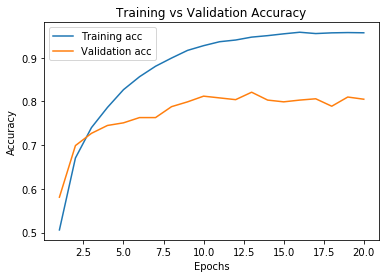

Optimal number of epochs based on validation accuracy: 13
Test accuracy with optimal epochs: 0.7956


In [1]:
# 1) Load Reuters and split train/val exactly as required
from keras.datasets import reuters
from keras import models, layers
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

(num_words) = 10000
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=num_words)

# 2) Vectorize sequences
def vectorize_sequences(sequences, dimension=num_words):
    x = np.zeros((len(sequences), dimension))
    for i, seq in enumerate(sequences):
        x[i, seq] = 1.0
    return x

# Train / Val split (7,982 / 1,000)
x_train = vectorize_sequences(train_data[:7982])
y_train = to_categorical(train_labels[:7982], num_classes=46)

x_val   = vectorize_sequences(train_data[7982:8982])
y_val   = to_categorical(train_labels[7982:8982], num_classes=46)

# Test set: all remaining 2,246 examples
x_test  = vectorize_sequences(test_data)            # shape (2246, 10000)
y_test  = to_categorical(test_labels, num_classes=46)

# 3) Build the model (same architecture as the example)
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(num_words,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(46, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()

# 4) Train with validation to select the optimal epoch
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=0
)

# 5) Plot training/validation accuracy vs. epochs
acc     = history.history.get('accuracy', history.history.get('acc'))
val_acc = history.history.get('val_accuracy', history.history.get('val_acc'))
epochs  = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc,     label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.title('Training vs Validation Accuracy')
plt.legend(); plt.show()

# 6) Choose optimal epoch (highest validation accuracy)
best_epoch = int(np.argmax(val_acc) + 1)
print("Optimal number of epochs based on validation accuracy:", best_epoch)

# 7) Retrain from scratch on ALL 8,982 (train + val) for 'best_epoch' epochs
x_full = np.vstack([x_train, x_val])
y_full = np.vstack([y_train, y_val])

final_model = build_model()
final_model.fit(x_full, y_full, epochs=best_epoch, batch_size=512, verbose=0)

# 8) Evaluate on the 2,246 test examples
test_loss, test_acc = final_model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy with optimal epochs:", round(test_acc, 4))
